<a href="https://colab.research.google.com/github/RMichae1/PyroStudies/blob/master/Bayesian_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy.random import random as np_random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from jax import ops, random
from jax.scipy.special import expit
import jax.numpy as jnp
from numpyro.diagnostics import hpdi

In [ ]:
iris_data = datasets.load_iris() 

In [ ]:
iris_df = pd.DataFrame(data=np.c_[iris_data['data'], iris_data['target']],
                      columns=iris_data['feature_names'] + ['target'])
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [ ]:
iris_df["target"] = iris_df.target.astype("int")
# select 2 species for ease of use
iris_df = iris_df[iris_df.target.isin([0, 1])]
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [ ]:
random_vec = np_random(iris_df["petal length (cm)"].shape)<0.5
iris_df["petal length (cm)"] = iris_df["petal length (cm)"].where(random_vec, 
                                                                  other=np.nan)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,NaN,0.2,0
2,4.7,3.2,NaN,0.2,0
3,4.6,3.1,NaN,0.2,0
4,5.0,3.6,NaN,0.2,0
...,...,...,...,...,...
95,5.7,3.0,NaN,1.2,1
96,5.7,2.9,NaN,1.3,1
97,6.2,2.9,NaN,1.3,1
98,5.1,2.5,NaN,1.1,1


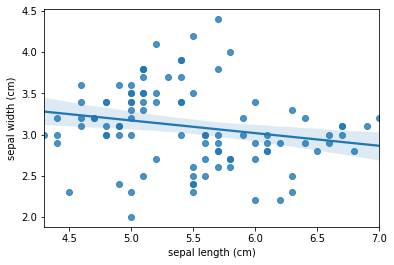

In [ ]:
sns.regplot("sepal length (cm)", "sepal width (cm)", iris_df)

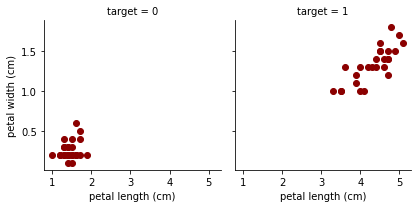

In [ ]:
t = sns.FacetGrid(iris_df, col="target")
t.map(plt.scatter, "petal length (cm)", "petal width (cm)", color="darkred")
plt.savefig("./lr_lw.png")

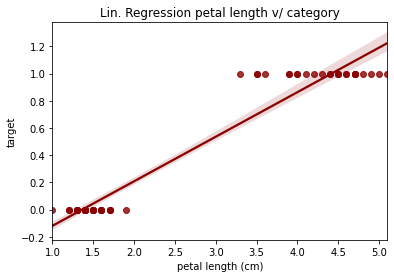

In [ ]:
sns.regplot("petal length (cm)", "target", color="darkred", data=iris_df)
plt.title("Lin. Regression petal length v/ category")
plt.savefig("./lr_target_p_len.png")

In [ ]:
iris_data=dict(s_len=iris_df["sepal length (cm)"].values,
              s_width=iris_df["sepal width (cm)"].values,
              p_len=iris_df["petal length (cm)"].values,
              p_width=iris_df["petal width (cm)"].values,
              target=iris_df.target.values)
iris_data

{'p_len': array([1.4, nan, nan, nan, nan, 1.7, 1.4, 1.5, nan, nan, nan, nan, nan,
        nan, 1.2, nan, 1.3, 1.4, nan, 1.5, 1.7, 1.5, 1. , 1.7, 1.9, 1.6,
        nan, nan, 1.4, 1.6, 1.6, nan, 1.5, 1.4, nan, 1.2, 1.3, 1.4, nan,
        nan, 1.3, 1.3, 1.3, 1.6, nan, nan, nan, 1.4, 1.5, 1.4, 4.7, 4.5,
        4.9, 4. , nan, nan, nan, nan, 4.6, nan, 3.5, nan, 4. , 4.7, 3.6,
        nan, nan, 4.1, nan, 3.9, 4.8, nan, nan, 4.7, 4.3, 4.4, nan, 5. ,
        nan, 3.5, nan, nan, 3.9, 5.1, 4.5, 4.5, 4.7, 4.4, nan, nan, nan,
        4.6, nan, 3.3, 4.2, nan, nan, nan, nan, nan]),
 'p_width': array([0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1,
        0.1, 0.2, 0.4, 0.4, 0.3, 0.3, 0.3, 0.2, 0.4, 0.2, 0.5, 0.2, 0.2,
        0.4, 0.2, 0.2, 0.2, 0.2, 0.4, 0.1, 0.2, 0.2, 0.2, 0.2, 0.1, 0.2,
        0.2, 0.3, 0.3, 0.2, 0.6, 0.4, 0.3, 0.2, 0.2, 0.2, 0.2, 1.4, 1.5,
        1.5, 1.3, 1.5, 1.3, 1.6, 1. , 1.3, 1.4, 1. , 1.5, 1. , 1.4, 1.3,
        1.4, 1.5, 1. , 1.5, 1.1, 1.8, 1.3, 1.5, 1

In [ ]:
print("Petal Length μ = {}".format(iris_df["petal length (cm)"].mean()))
print("Petal Length σ^2 = {}".format(iris_df["petal length (cm)"].std()))

Petal Length μ = 2.8072727272727267
Petal Length σ^2 = 1.4923079993698234


In [ ]:
p_len = iris_df["petal length (cm)"]
print("Amount missing: {}".format(len(np.array(np.isnan(p_len).astype(int)).nonzero()[0])))
np.array(np.isnan(p_len).astype(int)).nonzero()[0]

Amount missing: 50


array([ 3,  4,  7,  8, 14, 17, 22, 24, 25, 28, 31, 32, 35, 37, 39, 40, 42,
       45, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 66, 67,
       68, 70, 72, 75, 76, 80, 81, 82, 84, 85, 87, 88, 91, 93, 95, 99])

In [ ]:
def model(s_len, s_width, p_len, p_width, target=None):
    b_s_len = numpyro.sample("b_s_len", dist.Normal(0,1))
    b_s_width = numpyro.sample("b_s_width", dist.Normal(0,1))
    b_p_width = numpyro.sample("b_p_width", dist.Normal(0,1))
    
    # impute length
    len_mu = numpyro.sample("p_length_mu", dist.Normal(2.8, 0.2))
    len_sigma = numpyro.sample("p_length_sigma", dist.Normal(1.5, 0.2))
    len_is_nan = np.isnan(p_len)
    len_nan_idx = np.array(np.isnan(p_len).astype(int)).nonzero()[0]
    
    if target is not None:
        len_impute = numpyro.param("len_impute", np.zeros(len_is_nan.sum()))
    else:
        len_impute = numpyro.sample("len_impute", dist.Normal(len_mu[len_nan_idx], 
                                                              len_sigma[len_nan_idx]))
    p_len = ops.index_update(p_len, len_nan_idx, len_impute)
    
    numpyro.sample("p_length", dist.Normal(len_mu, len_sigma), obs=p_len)
    
    l = numpyro.sample("l", dist.Normal(0, 1))
    b_len = numpyro.sample("b_length", dist.Normal(0, 1))
    logits = l + b_len * p_len
    
    logits = logits + b_s_len*s_len + b_s_width*s_width + b_p_width*p_width
    if target is None:
        # prediction case
        probs = expit(logits)
        numpyro.sample("probs", dist.Delta(probs))

    numpyro.sample("target", dist.Bernoulli(logits=logits), obs=target)

In [ ]:
mcmc = MCMC(NUTS(model=model), 5000, 10000, num_chains=1)
mcmc.run(random.PRNGKey(42), **iris_data)

mcmc.print_summary()

/usr/local/lib/python3.6/dist-packages/numpyro/infer/hmc.py:415: UserWarning: 'param' sites will be treated as constants during inference. To define an improper variable, please use a 'sample' site with log probability masked out. For example, `sample('x', dist.LogNormal(0, 1).mask(False)` means that `x` has improper distribution over the positive domain.
  warnings.warn("'param' sites will be treated as constants during inference. To define "
sample: 100%|██████████| 15000/15000 [00:27<00:00, 544.01it/s, 31 steps of size 1.03e-01. acc. prob=0.96]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
        b_length      0.15      0.31      0.14     -0.37      0.62   8255.63      1.00
       b_p_width      3.16      0.74      3.14      1.89      4.32   6341.96      1.00
         b_s_len      1.02      0.44      1.02      0.30      1.76   4147.86      1.00
       b_s_width     -2.51      0.65     -2.50     -3.58     -1.42   4549.90      1.00
               l     -0.36      0.96     -0.36     -1.92      1.23   8606.05      1.00
     p_length_mu      1.89      0.13      1.89      1.67      2.11   8523.08      1.00
  p_length_sigma      1.67      0.10      1.67      1.49      1.83   8173.70      1.00

Number of divergences: 0


In [ ]:
samples = mcmc.get_samples()

In [ ]:
samples

{'b_length': DeviceArray([ 0.61443835, -0.13149726,  0.1586218 , ...,  0.22617479,
              -0.18041043,  0.23004642], dtype=float32),
 'b_p_width': DeviceArray([2.3086004, 2.921801 , 2.3608851, ..., 1.6921166, 3.4737377,
              3.2055209], dtype=float32),
 'b_s_len': DeviceArray([1.2534572, 1.5330684, 1.068358 , ..., 1.4390019, 1.5570893,
              1.8925159], dtype=float32),
 'b_s_width': DeviceArray([-3.3704524, -2.7095535, -2.7780566, ..., -2.3638937,
              -3.7990289, -4.2991133], dtype=float32),
 'l': DeviceArray([ 0.80662984, -2.515109  ,  1.2743905 , ..., -2.4266136 ,
               1.38187   ,  0.96063715], dtype=float32),
 'p_length_mu': DeviceArray([1.7891338, 2.039834 , 1.9705244, ..., 2.0696154, 1.7796098,
              2.0797315], dtype=float32),
 'p_length_sigma': DeviceArray([1.6882048, 1.6664714, 1.7581732, ..., 1.7149489, 1.6834022,
              1.7027632], dtype=float32)}

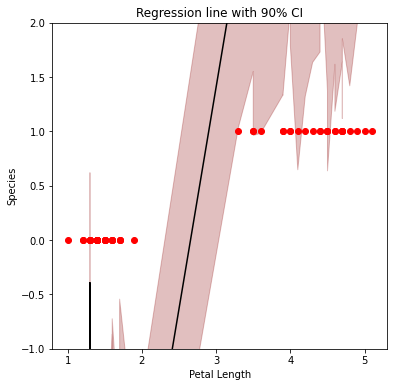

In [ ]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    petal_length = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    species = iris_df.target.values[idx]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(petal_length, mean, 'k')
    ax.plot(petal_length, species, 'ro')
    ax.fill_between(petal_length, hpdi[0], hpdi[1], alpha=0.25, color="darkred", interpolate=False)
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples['l'], -1) + \
               jnp.expand_dims(samples['b_length'], -1) * iris_df["petal length (cm)"].values + \
               jnp.expand_dims(samples['b_s_len'], -1)*iris_df["sepal length (cm)"].values + \
               jnp.expand_dims(samples['b_s_width'], -1)*iris_df["sepal width (cm)"].values + \
               jnp.expand_dims(samples['b_p_width'], -1)*iris_df["petal width (cm)"].values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.95)
ax = plot_regression(iris_df["petal length (cm)"].values, mean_mu, hpdi_mu)
ax.set(xlabel='Petal Length', ylabel='Species', title='Regression line with 90% CI')
ax.set_ylim([-1, 2]);
plt.savefig("rp_sampled_90CI.png")